Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchains);
# Use 16 observations
N2 = 15
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));

Show first 5 (generated) observations

In [5]:
k2 = rand(d, N2);
k2[1:min(5, N2)]

5-element Array{Int64,1}:
 8
 5
 7
 5
 7

Input data for cmdstan

In [6]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.031, 0.030, 0.029, 0.030) seconds, 0.12 seconds total
Sampling took (0.043, 0.047, 0.042, 0.043) seconds, 0.18 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -89  2.6e-02     1.1    -91   -89   -88  1.8e+03  1.0e+04  1.0e+00
accept_stat__   0.90  1.9e-03    0.13   0.62  0.95   1.0  4.5e+03  2.5e+04  1.0e+00
stepsize__      0.85  1.3e-02   0.018   0.84  0.85  0.89  2.0e+00  1.1e+01  1.2e+13
treedepth__      1.9  1.1e-02    0.61    1.0   2.0   3.0  3.4e+03  1.9e+04  1.0e+00
n_leapfrog__     4.4  1.5e-01     8.9    1.0   3.0    11  3.7e+03  2.1e+04  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          90  3.6e-02     1.4     89    90    93  1.6e+03  9.1e+03  1.0e+00
theta           0.67  6.7e-04   0.040  

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │ ess    │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │ Any    │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┼────────┤
│ 1   │ theta      │ 0.671669 │ 0.0395072 │ 0.000624663 │ 0.000733476 │ 4000.0 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.594328 │ 0.644391 │ 0.671848 │ 0.699555 │ 0.745366 │


Allocate array of Normal fits

In [8]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.6714558899999998, σ=0.03924418369440112)
Normal{Float64}(μ=0.6713632200000004, σ=0.03871279059233006)
Normal{Float64}(μ=0.6721915630000002, σ=0.03886336791751366)
Normal{Float64}(μ=0.6716638929999994, σ=0.04113563867205116)


Plot the 4 chains

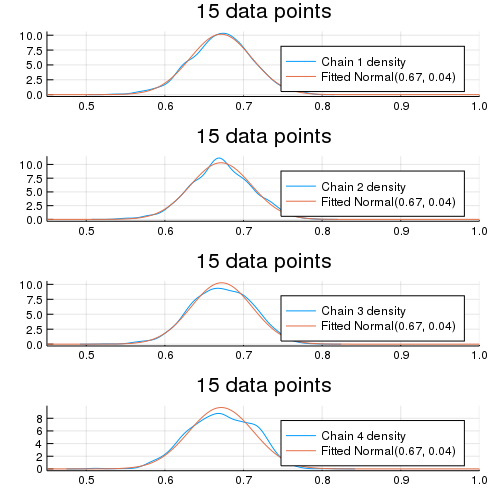

In [9]:
mu_avg = sum([fits[i].μ for i in 1:4]) / 4.0;
sigma_avg = sum([fits[i].σ for i in 1:4]) / 4.0;

if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

Show the hpd region

In [10]:
hpd(chn, alpha=0.055)

HPD

│ Row │ parameters │ upper    │ lower    │
│     │ Symbol     │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.600804 │ 0.748432 │

Compute the hpd bounds for plotting

In [11]:
d, p, c = size(chn);
theta = convert(Vector{Float64}, reshape(chn.value, (d*p*c)));
bnds = quantile(theta, [0.045, 0.945])

2-element Array{Float64,1}:
 0.604332545
 0.73324594 

Show hpd region

In [12]:
println("hpd bounds = $bnds\n")

hpd bounds = [0.604332545, 0.73324594]



quadratic approximation

Compute MAP, compare with CmndStan & MLE

In [13]:
tmp = convert(Array{Float64,3}, chn.value)
draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)

4000-element Array{Float64,1}:
 0.640373
 0.640373
 0.723583
 0.700049
 0.690882
 0.651197
 0.67589 
 0.628031
 0.671476
 0.677454
 ⋮       
 0.614249
 0.71417 
 0.676937
 0.638862
 0.666308
 0.642069
 0.664382
 0.645125
 0.726119

Compute MAP

In [14]:
using Optim

x0 = [0.5]
lower = [0.2]
upper = [1.0]

inner_optimizer = GradientDescent()

function loglik(x)
  ll = 0.0
  ll += log.(pdf.(Beta(1, 1), x[1]))
  ll += sum(log.(pdf.(Binomial(9, x[1]), k2)))
  -ll
end

res = optimize(loglik, lower, upper, x0, Fminbox(inner_optimizer))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.5]
 * Minimizer: [0.6740740740542536]
 * Minimum: 2.418087e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.77e-11 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.93e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 87
 * Gradient Calls: 87

Summarize mean and sd estimates

CmdStan mean and sd:

In [15]:
[mean(chn.value), std(chn.value)]

2-element Array{Float64,1}:
 0.6716686415        
 0.039507154650583534

MAP estimate and associated sd:

In [16]:
[Optim.minimizer(res)[1], std(draws, mean=mean(chn.value))]

2-element Array{Float64,1}:
 0.6740740740542536  
 0.039507154650583534

MLE of mean and sd:

In [17]:
[mu_avg, sigma_avg]

2-element Array{Float64,1}:
 0.6716686414999999
 0.039488995219074 

Turing Chain &  89% hpd region boundaries

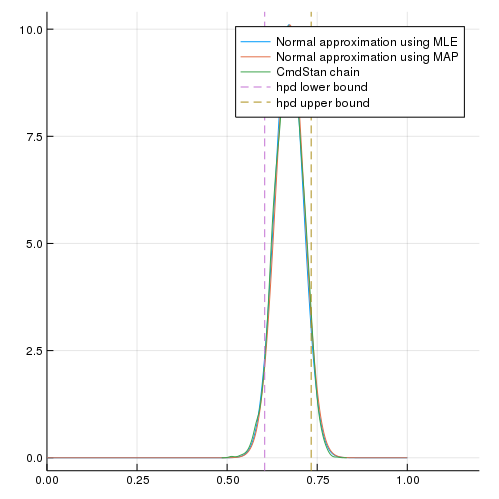

In [18]:
plot( x, pdf.(Normal( mu_avg , sigma_avg  ) , x ),
xlim=(0.0, 1.2), lab="Normal approximation using MLE")
plot!( x, pdf.(Normal( Optim.minimizer(res)[1] , std(draws, mean=mean(chn.value))) , x),
lab="Normal approximation using MAP")
density!(draws, lab="CmdStan chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

End of `02/clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*